## Topic Modeling
This notebook performs Topic modeling on the classified dataset (BERT) using LDA.
#### Author: Rishikesh Kakde

#### Import Libraries

In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis.gensim
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import pyLDAvis.gensim as gensimvis

In [2]:
# Download NLTK data
nltk.download('stopwords')
nltk.download('punkt')

# Load English stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rishikeshkakde/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rishikeshkakde/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Load Dataset with Sentiment Labels

In [3]:
# Load the analysis dataset with predicted sentiments
file_path = 'analysis_dataset_with_sentiments.csv'
df = pd.read_csv(file_path)

print(f"Number of entries in the dataset: {len(df)}")

# Separate positive and negative reviews
positive_reviews = df[df['predicted_sentiment'] == 'positive']['text'].dropna().tolist()
negative_reviews = df[df['predicted_sentiment'] == 'negative']['text'].dropna().tolist()

# Display counts
print(f"Number of positive reviews: {len(positive_reviews)}")
print(f"Number of negative reviews: {len(negative_reviews)}")

Number of entries in the dataset: 1500
Number of positive reviews: 560
Number of negative reviews: 235


The rest of the reviews are neither positive not negative were neutral and are not included in this analysis.

#### Preprocessing Function

In [4]:
nltk.download('wordnet')
nltk.download('punkt')  # Download the 'punkt' tokenizer resource
nltk.download('punkt_tab')  # Download the 'punkt_tab' tokenizer resource


# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to preprocess text
def preprocess_text(text):
    # Tokenize text
    tokens = word_tokenize(text.lower())
    # Remove stopwords and non-alphanumeric tokens, and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in stop_words]
    return tokens

# Preprocess positive and negative reviews
positive_processed = [preprocess_text(review) for review in positive_reviews]
negative_processed = [preprocess_text(review) for review in negative_reviews]

print("Sample preprocessed positive review:", positive_processed[0])
print("Sample preprocessed negative review:", negative_processed[0])

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/rishikeshkakde/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rishikeshkakde/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/rishikeshkakde/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Sample preprocessed positive review: ['kiddos', 'love', 'show']
Sample preprocessed negative review: ['annabella', 'sciorra', 'character', 'justice', 'portrayal', 'mentally', 'ill', 'depressed', 'traumatized', 'individual', 'project', 'much', 'inner', 'wound', 'onto', 'others', 'challenge', 'face', 'father', 'sensitively', 'portrayed', 'resonate', 'understanding', 'love', 'ending', 'really', 'ending', 'though', 'feel', 'like', 'abandoned', 'enough', 'closure', 'decent', 'movie', 'sit', 'type', 'person', 'like', 'analyze', 'action', 'others', 'feel', 'also', 'somewhat', 'comforting']


#### Prepare Data for LDA

In [5]:
# Create a dictionary and corpus for positive reviews
positive_dict = corpora.Dictionary(positive_processed)
positive_corpus = [positive_dict.doc2bow(text) for text in positive_processed]

# Create a dictionary and corpus for negative reviews
negative_dict = corpora.Dictionary(negative_processed)
negative_corpus = [negative_dict.doc2bow(text) for text in negative_processed]

#### Find the Optimal Number of Topics Using Coherence Score

In [6]:
def compute_coherence(dictionary, corpus, texts, start=2, limit=10, step=1):
    coherence_scores = []
    models_list = []
    for num_topics in range(start, limit, step):
        lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42, passes=10)
        coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_scores.append(coherence_model.get_coherence())
        models_list.append(lda_model)
    return models_list, coherence_scores

# Compute coherence scores for positive reviews
positive_models, positive_coherence_scores = compute_coherence(positive_dict, positive_corpus, positive_processed)

# Compute coherence scores for negative reviews
negative_models, negative_coherence_scores = compute_coherence(negative_dict, negative_corpus, negative_processed)

# Display coherence scores
print("Positive review coherence scores:", positive_coherence_scores)
print("Negative review coherence scores:", negative_coherence_scores)

Positive review coherence scores: [0.279681287854177, 0.23238157632760084, 0.2627705061545051, 0.26606049097877243, 0.3058606596353056, 0.27941197424970404, 0.30802971879775465, 0.29176935159987616]
Negative review coherence scores: [0.2816400906720219, 0.2773348825818187, 0.29491520920624026, 0.2781154076179133, 0.2936168195823688, 0.3040637495059348, 0.2794366668908759, 0.2855472920190087]


#### Select the Best Model Based on Coherence Score

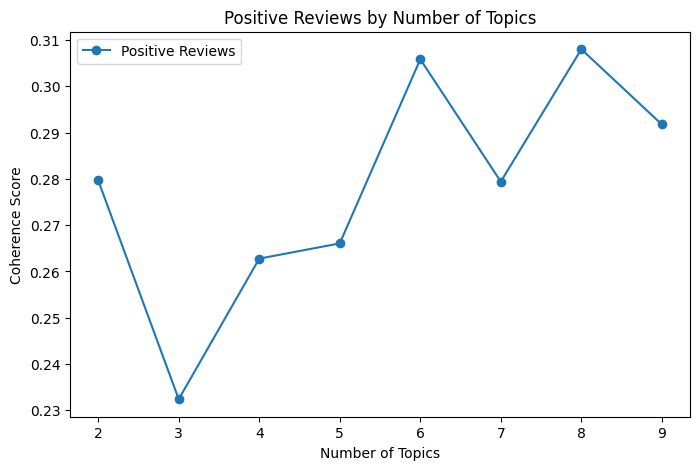

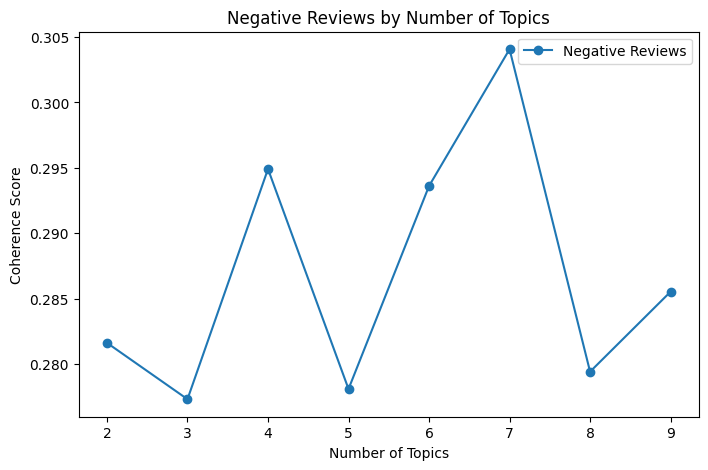

In [7]:
def plot_coherence(coherence_scores, start=2, limit=10, step=1, label="Coherence"):
    x = range(start, limit, step)
    plt.figure(figsize=(8, 5))
    plt.plot(x, coherence_scores, marker='o', label=label)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Score")
    plt.legend()
    plt.title(f"{label} by Number of Topics")
    plt.show()

# Plot coherence for positive and negative reviews
plot_coherence(positive_coherence_scores, label="Positive Reviews")
plot_coherence(negative_coherence_scores, label="Negative Reviews")

# Choose the best model (manually based on the plot or coherence score)
best_positive_model = positive_models[positive_coherence_scores.index(max(positive_coherence_scores))]
best_negative_model = negative_models[negative_coherence_scores.index(max(negative_coherence_scores))]

**Insights from the visualizations**
- For positive reviews, the optimal number of topics based on coherence score appears to be 6 or 8, as they yield the highest coherence scores.

- For negative reviews, the optimal number of topics based on coherence score appears to be 7, as it has the highest coherence score.

#### Visualize the Topics with PyLDAvis

In [9]:
# Visualize topics for positive reviews
positive_vis = gensimvis.prepare(best_positive_model, positive_corpus, positive_dict)
pyLDAvis.display(positive_vis)

In [10]:
# Visualize topics for negative reviews
negative_vis = gensimvis.prepare(best_negative_model, negative_corpus, negative_dict)
pyLDAvis.display(negative_vis)

#### Exporting to HTML to visualize and screenshot for the paper

In [11]:
# Save positive review visualization to HTML
pyLDAvis.save_html(positive_vis, 'positive_reviews_topics.html')

# Save negative review visualization to HTML
pyLDAvis.save_html(negative_vis, 'negative_reviews_topics.html')

print("Visualizations saved as 'positive_reviews_topics.html' and 'negative_reviews_topics.html'.")

Visualizations saved as 'positive_reviews_topics.html' and 'negative_reviews_topics.html'.
